#DATA VISUALISATION
#20BCE1731 Arnav Singh
#20BCE1773 Archit Agarwal

# Cleaning, processing and first exploration

As seen below, this data set consists of (supposedly) all games since the inaugural Scotland - England in 1872. For each game, we have the score, the tournament, the host city and country.



In [4]:

### Loading libraries
library(ggplot2) # Data visualization
library(readr) # CSV file I/O, e.g. the read_csv function
library(dplyr)



In [2]:
# Reading input file.
df <- read_csv("results.csv")
head(df)


Rows: 28274 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (5): home_team, away_team, tournament, city, country
dbl  (2): home_score, away_score
lgl  (1): neutral
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
<date>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<lgl>
1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,FALSE
1873-03-08,England,Scotland,4,2,Friendly,London,England,FALSE
1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,FALSE
1875-03-06,England,Scotland,2,2,Friendly,London,England,FALSE
1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,FALSE
1876-03-25,Scotland,Wales,4,0,Friendly,Glasgow,Scotland,FALSE


Let's check if we hace some NA or NULL values we should clean.
Apparently not. Good news, let's continue.

In [5]:
apply(df, 2, function(v) {length(which(is.na(v) | is.null(v)))})

date  home_team  away_team home_score away_score tournament       city 
         0          0          0          0          0          0          0 
   country    neutral 
         0          0

Let's process a bit the data so that we can have a quicker access to some important feature such as the result or the names of the winning or losing team. The outcome of a game will be encoded as D for draw, H for the home team winning and A for the away team winning. We will also extract some date-related features such as the day of week or month.

In [6]:
game_outcome <- function(home_score, away_score) {
        outcome <- "D"
        if (home_score > away_score) {outcome <- "H"}
        if (home_score < away_score) {outcome <- "A"}
    return(outcome)
}

winning_team <- function(home_score, away_score, home_team, away_team) {
        winning_team <- NA
        if (home_score > away_score) {winning_team <- home_team}
        if (home_score < away_score) {winning_team <- away_team}
    return(winning_team)
}

losing_team <- function(home_score, away_score, home_team, away_team) {
        losing_team <- NA
        if (home_score < away_score) {losing_team <- home_team}
        if (home_score > away_score) {losing_team <- away_team}
    return(losing_team)
}

df <- df %>%
    mutate(year = format(date, "%Y"),
          month = format(date, "%b"),
          dayofweek = weekdays(date)) %>%
    rowwise() %>%
    mutate(outcome = game_outcome(home_score, away_score),
          winning_team = winning_team(home_score, away_score, home_team, away_team),
          losing_team = losing_team(home_score, away_score, home_team, away_team)) %>%
    ungroup()


head(df)

date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year,month,dayofweek,outcome,winning_team,losing_team
<date>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,FALSE,1872,Nov,Saturday,D,NA,NA
1873-03-08,England,Scotland,4,2,Friendly,London,England,FALSE,1873,Mar,Saturday,H,England,Scotland
1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,FALSE,1874,Mar,Saturday,H,Scotland,England
1875-03-06,England,Scotland,2,2,Friendly,London,England,FALSE,1875,Mar,Saturday,D,NA,NA
1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,FALSE,1876,Mar,Saturday,H,Scotland,England
1876-03-25,Scotland,Wales,4,0,Friendly,Glasgow,Scotland,FALSE,1876,Mar,Saturday,H,Scotland,Wales


Now, let's do some basic exploration. How many entries? Answer > 38k matches.

In [7]:
dim(df)

[1] 28274    15

# A journey through the historical landscape of international soccer

## Which teams play the most?

Let's start by checking which are the most represented teams? This will tell us which are the team with the richest history.

Surprisingly, Sweden is the team who has played the most games. Most top 10 countries are major soccer nation such as Brazil, Argentina, England, Germany or France. Countries such as Ururguay, Mexico and Hungary are also old teams as they participated to the first world cups (1930 and/or 1934).

In [8]:
all_teams <- data.frame(teams = c(df$home_team, df$away_team), year=as.numeric(c(df$year, df$year)))

all_teams_count <- all_teams %>%
    group_by(teams) %>%
    summarise(number_games = length(teams)) %>%
    arrange(desc(number_games))

head(all_teams_count, 10)

teams,number_games
<chr>,<int>
England,840
Sweden,832
Hungary,793
Argentina,792
Brazil,788
Germany,755
Uruguay,713
Norway,662
Scotland,662


It is likely all these teams have a different trajectory, some might have start playing earlier and some later. The plot below displays the cumulative sum of the number of matches for these top 10 teams. Hover the line to display the name of the team. You can also click on a team's name to hide/show it.

## How many games per year?

Let's now check how many games were played each year and how the total number of international games evolve with time.

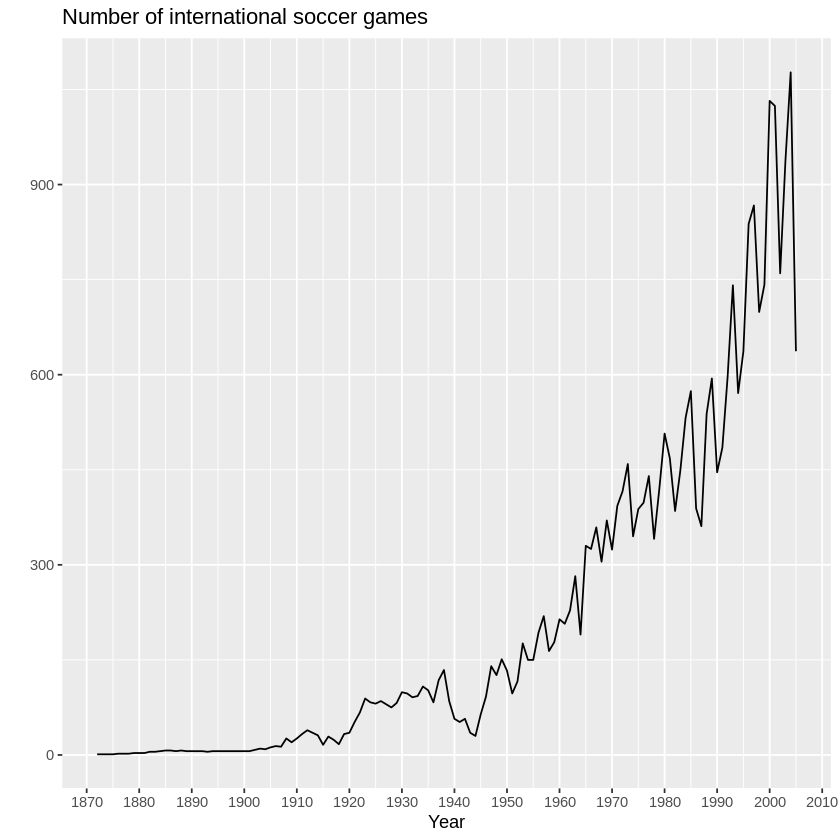

In [9]:
tmp <- df %>%
    filter(year < 2018) %>%
    mutate(year = as.numeric(year)) %>%
    group_by(year) %>%
    summarise(nb_games = length(date))  %>%
    ungroup()

ggplot(tmp, aes(x=year, y=nb_games, group=1)) +
geom_line() +
labs(x="Year", title="Number of international soccer games", y="") +
scale_x_continuous(breaks=seq(1870, 2020, 10))

There are few interestings things going on here:
* Number of games is rising, with high growth in the 80s/90s.
* It seems there is a peak around 2010, with a slight decrease since.
* We see a drop during world wars.
* Since the 80s, data is very spiky, likely due to the absence/presence of world cups or other events.

Let's try to visualise this to add some understanding to our plot.

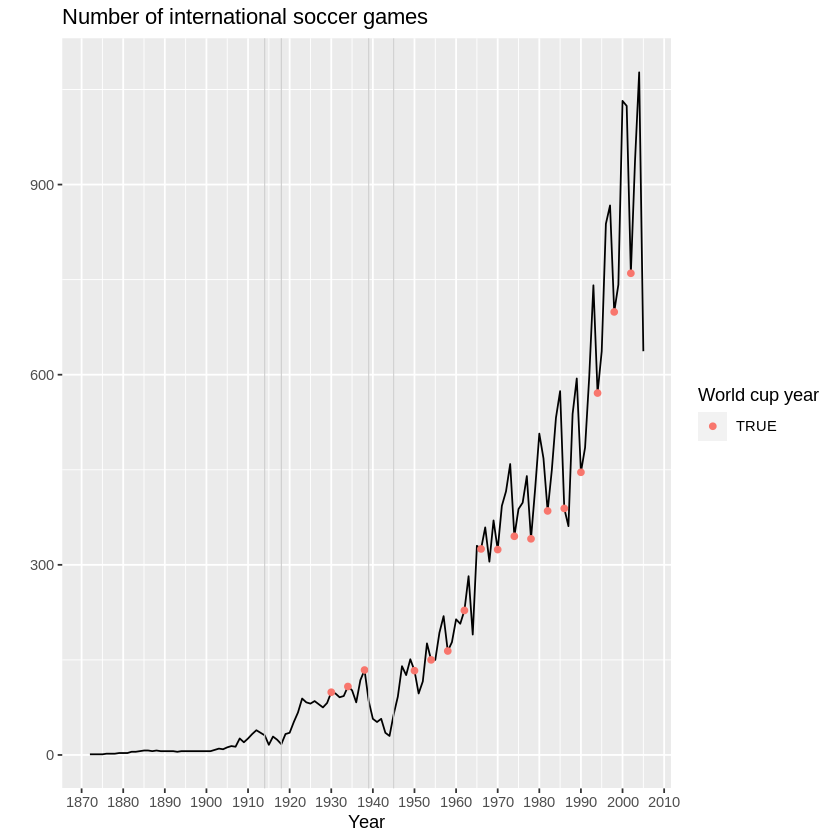

In [10]:
wc_years <- c(1930, 1934, 1938, seq(1950, 2014, 4))

tmp <- tmp %>%
    mutate(is_wc = year %in% wc_years)

ggplot(tmp, aes(x=year, y=nb_games, group=1)) +
geom_line() +
geom_point(data = tmp %>% filter(is_wc), aes(colour=is_wc)) +
labs(x="Year", title="Number of international soccer games", y="", colour="World cup year") +
geom_vline(xintercept=c(1914,1918,1939,1945), lwd=0.3, colour="gray80") +
scale_x_continuous(breaks=seq(1870, 2020, 10))


The two main drops indeed correspond to the 2 world wars but, surprisingly, the world cup years are those counting less matches.

Let's investigate which are the most common game types and competitions every year, since 2000.

In [11]:
df_competitions <- df %>%
    group_by(tournament, year) %>%
summarise(nb_games = length(date))

`summarise()` has grouped output by 'tournament'. You can override using the
`.groups` argument.


Warning message:
“The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as
of ggplot2 3.3.4.”


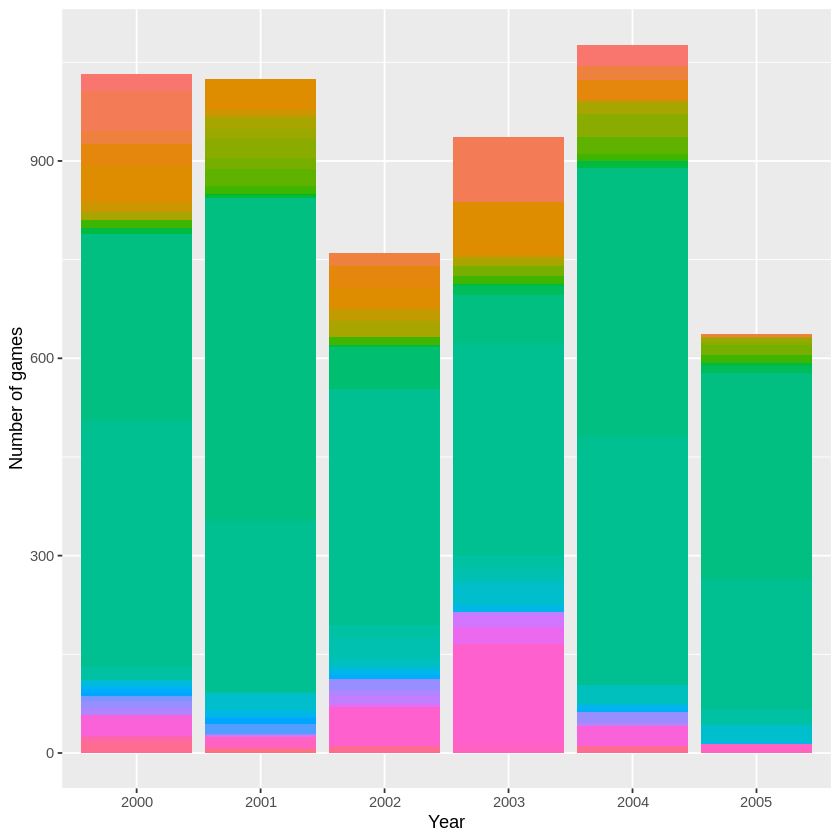

In [12]:
ggplot(df_competitions %>% filter(year >= 2000 & year < 2018),
       aes(x=year, y=nb_games, fill=tournament)) +
geom_bar(stat="identity") +
guides(fill=FALSE) +
labs(x="Year", y="Number of games")

We can see that some events/tournaments are more frequent on non-world cup years such as 2007 or 2011. Let's check what they are.

In [13]:
df_competitions %>% filter(year == 2011) %>% arrange(desc(nb_games))

tournament,year,nb_games
<chr>,<chr>,<int>


In [14]:
df_competitions %>% filter(year == 2010) %>% arrange(desc(nb_games))

tournament,year,nb_games
<chr>,<chr>,<int>


World cup qualifications generates much more matches than the world cup itself, which makes sense as the World Cup only concerns 32 countries. This is well shown in the two plost below: there is no WC qualification matches during a World Cup year and the number of qualification matches is greater than then number of WC matches by a factor 3 to 7 in general.

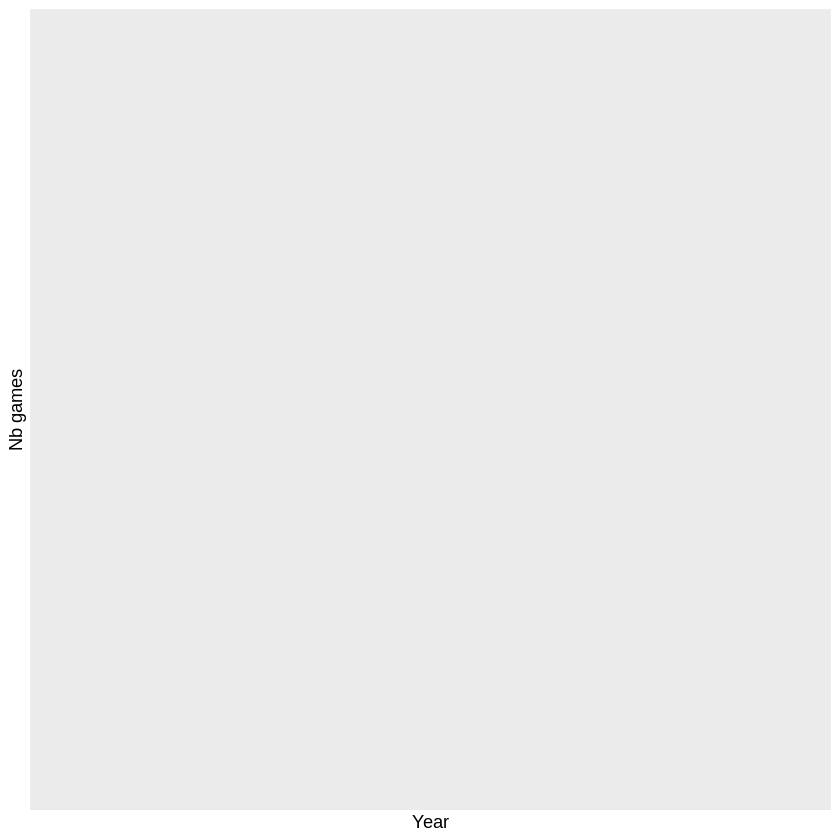

In [15]:
df_competition_filtered <- df_competitions %>% 
    filter(year >= 2006 & year < 2018 & tournament %in% c("Friendly","UEFA Euro qualification","FIFA World Cup", "FIFA World Cup qualification", "African Cup of Nations qualification")) 

ggplot(df_competition_filtered, aes(x=year, y=nb_games, group=tournament, colour=tournament)) +
geom_point() +
geom_line() +
labs(x="Year", y="Nb games", colour="Competition")

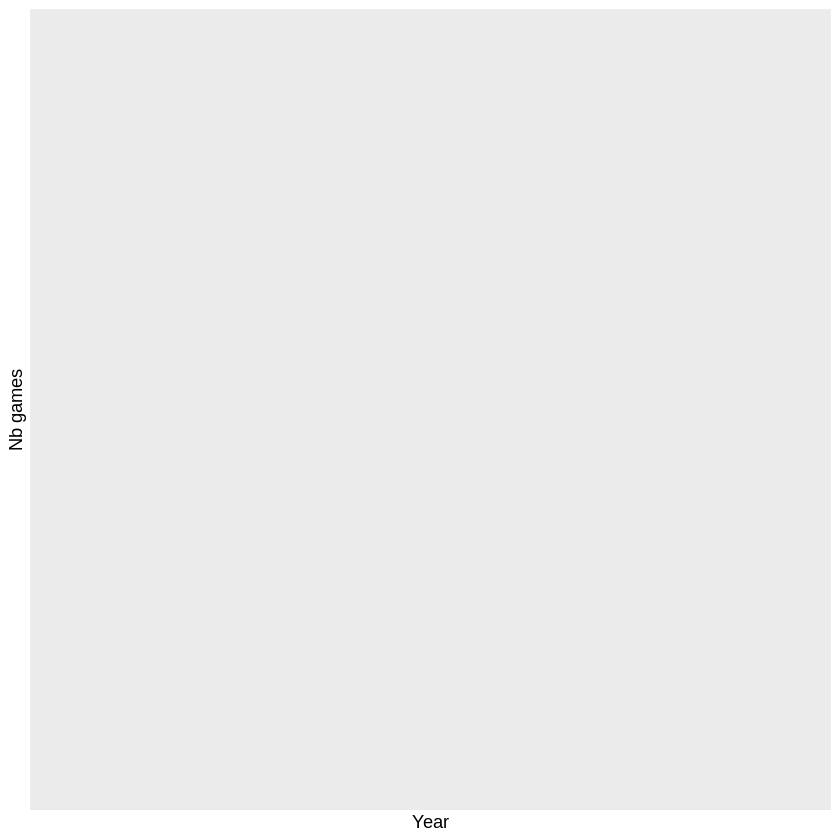

In [16]:
ggplot(df_competition_filtered, aes(x=year, y=nb_games, group=tournament, fill=tournament)) +
geom_bar(stat="identity") +
labs(x="Year", y="Nb games", fill="Competition")

## Evolution of results

Let' know talk about sport and  actual results! First let's check how the proportion of draws and home/away victories evolve through time. Main learnings are:
* A victory of the home-based team has always been the most likely event.
* A victory of the visitors is the second most likely outcome, although it tends to decrease in the second half of the 20th century.
* A draw has always been the least likely outcome, altough it has increased in share since the 1940's.

*It is to be noted that the "home" team isn't always playing on his own country, as for example during world or continental cups.*

`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.
`geom_smooth()` using formula = 'y ~ x'


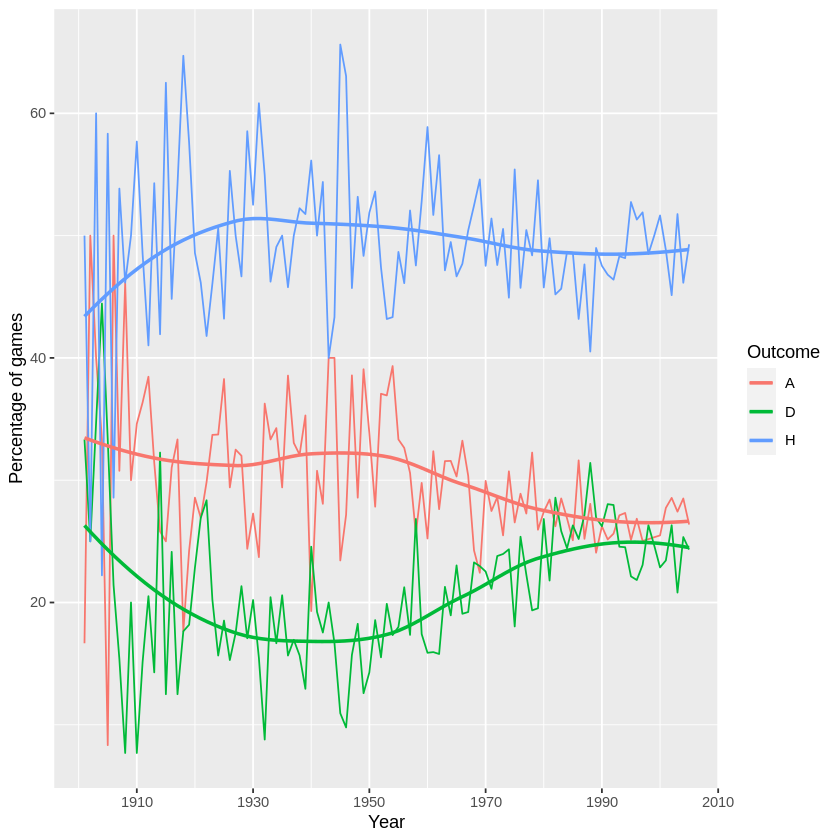

In [17]:
df_outcome_per_year <- df %>%
    mutate(year = as.numeric(year)) %>%
    group_by(year, outcome) %>%
    summarise(n = length(year)) %>%
    group_by(year) %>%
    mutate(total_year = sum(n),
          perc = n / total_year * 100)

ggplot(df_outcome_per_year %>% filter(year > 1900 & year < 2018), aes(x=year, y=perc, group=outcome, colour=outcome)) +
geom_line() +
labs(x="Year", y="Percentage of games", colour="Outcome") +
geom_smooth(se=FALSE, method="loess") +
scale_x_continuous(breaks = seq(1870, 2020, 20)) 



Let's now get to what is at the heart of soccer: goals! How did this evolve with time?

Although it started low (the first game resulted in a 0-0 between Scotland and England), then number of goals per games quickly skyrocketed and, before 1900, the average number of goals per game per year could be as high as 8!
This average then stabilized around 4 until 1950 and then decreased down to 2.5 in a more modern era. The 80's has been the period were games delivered the lowest number of goals.

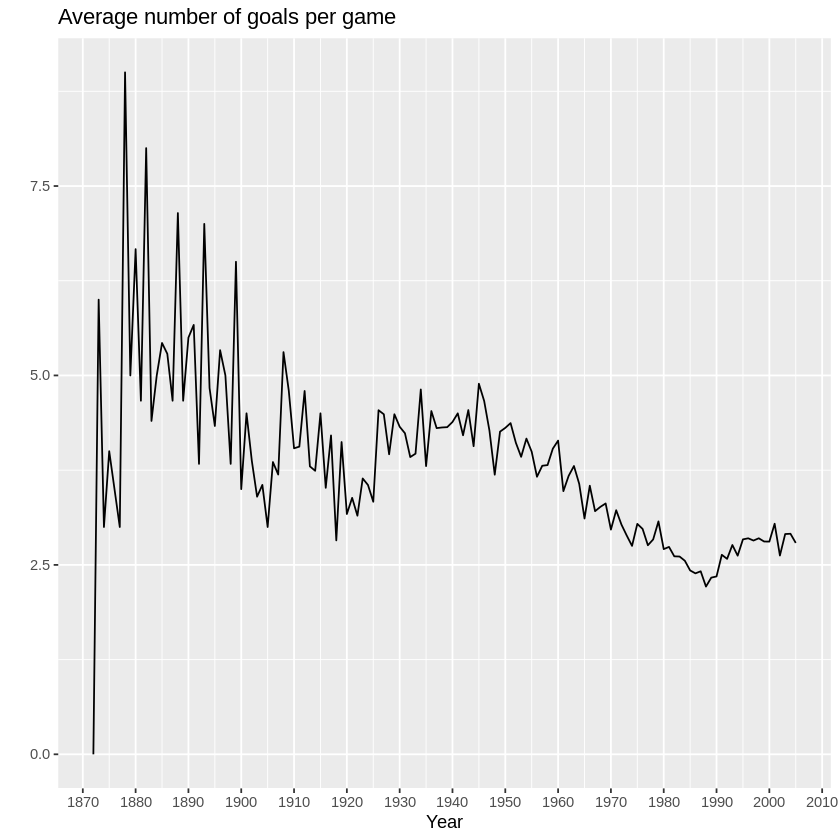

In [18]:
df_goals_per_game <- df %>%
    mutate(year = as.numeric(year)) %>%
    group_by(year) %>%
    summarise(nb_games = length(year),
             nb_goals = sum(home_score + away_score),
             goals_per_game = nb_goals / nb_games)

ggplot(df_goals_per_game, aes(x=year, y = goals_per_game)) +
    geom_line() +
    labs(x="Year", y="", title="Average number of goals per game") +
    scale_x_continuous(breaks = seq(1870, 2020, 10)) 



# Best performing teams during soccer history

## Which teams were consistent high scorer and good defender across time?

We have seen how games became globally less prolific in goals, but what about teams? Did some teams always scored a lot or, at contrary, were some always great defenders? 
First, let's transform a bit the data for this purpose. We will now have two entries per game, one from the perspective of each team.

In [19]:
games_info_home <- function(v) {
    team1 = v["home_team"]
    team1_gf <- v["home_score"]
    team1_ga <- v["away_score"]
    team1_outcome <-  "D"
    if (team1_gf > team1_ga) {team1_outcome <- "W"}
    if (team1_gf < team1_ga) {team1_outcome <- "L"}
    
    res1 <- c(v["date"], v["year"], v["tournament"], team1, v["away_team"],team1_gf, team1_ga, team1_outcome, "H")
    return(res1)
   }

games_info_away <- function(v) {
    team2 = v["away_team"]
    team2_gf <- v["away_score"]
    team2_ga <- v["home_score"]
    team2_outcome <-  "D"
    if (team2_gf > team2_ga) {team2_outcome <- "W"}
    if (team2_gf < team2_ga) {team2_outcome <- "L"}
    
    res2 <- c(v["date"], v["year"], v["tournament"], team2, v["home_team"],team2_gf, team2_ga, team2_outcome, "A")

    return(res2)

}

df_teams_games_home <- t(apply(df, 1, games_info_home))
df_teams_games_away <- t(apply(df, 1, games_info_away))
df_teams_games <- rbind(df_teams_games_home, df_teams_games_away)

colnames(df_teams_games) <- c("date", "year", "tournament", "team", "opponent", "team_score", "opponent_score", "team_outcome", "where")

df_teams_games <- as.data.frame(df_teams_games) %>%
    mutate(date=as.Date(date),
          year = as.numeric(as.character(year))) %>%
    mutate(team_score = as.numeric(as.character(team_score)),
          opponent_score = as.numeric(as.character(opponent_score))) %>%
    arrange(date)

head(df_teams_games, 10)

,date,year,tournament,team,opponent,team_score,opponent_score,team_outcome,where
,<date>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
1,1872-11-30,1872,Friendly,Scotland,England,0,0,D,H
2,1872-11-30,1872,Friendly,England,Scotland,0,0,D,A
3,1873-03-08,1873,Friendly,England,Scotland,4,2,W,H
4,1873-03-08,1873,Friendly,Scotland,England,2,4,L,A
5,1874-03-07,1874,Friendly,Scotland,England,2,1,W,H
6,1874-03-07,1874,Friendly,England,Scotland,1,2,L,A
7,1875-03-06,1875,Friendly,England,Scotland,2,2,D,H
8,1875-03-06,1875,Friendly,Scotland,England,2,2,D,A
9,1876-03-04,1876,Friendly,Scotland,England,3,0,W,H


#Best Defense and Attack per decade

In [20]:
df_teams_goals_per_decade <- df_teams_games %>%
    mutate(decade = cut(year, seq(1870,2020, 10), dig.lab = 4, right=FALSE)) %>%
    group_by(team, decade) %>%
    summarise(gf_per_game = sum(team_score) / length(date),
             ga_per_game = sum(opponent_score) / length(date),
             total_games = length(date),
             min_year = min(year)) %>%
    ungroup() %>%
    group_by(decade) %>%
    mutate(min_year = min(min_year),
        decade_year = paste(min_year, "'s", sep=""))

`summarise()` has grouped output by 'team'. You can override using the
`.groups` argument.


In [21]:
df_teams_goals_per_decade_top_gf <- df_teams_goals_per_decade %>%
    group_by(decade_year) %>%
    filter(total_games > 10) %>%
    top_n(n=6, wt=gf_per_game) %>%
    ungroup() %>%
    arrange(desc(decade_year), desc(gf_per_game)) %>%
    mutate(ord = rev(row_number())) 



Best scoring teams have changed quite a lot through the different decades in soccer history. Some of the lessons we can learn are:

* Scotland once, was one of the top scoring nations and slowly dropped from the top 6.
* Sweden was consistently in the top 6 for 4 decades in a row (1910s to 1940s).
* Fiji and Tahiti were at the top of the charts during some decades too, including some recent ones.
* Zambia and China once were among the top scorers.
* During the last 3 decades, Germany and Spain are the only major nations who made it twice to the top 6.

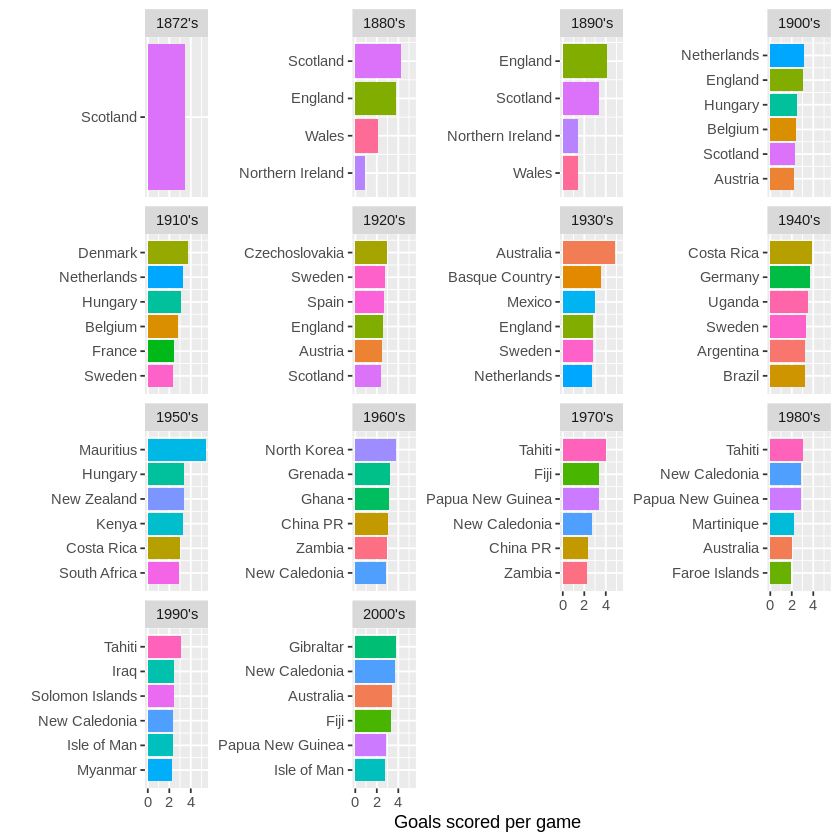

In [22]:
ggplot(df_teams_goals_per_decade_top_gf, aes(x=ord, y=gf_per_game, fill=team)) + 
    geom_bar(stat="identity") +
    facet_wrap(~decade_year, scales="free_y") +
    coord_flip() +
    scale_x_continuous(labels=df_teams_goals_per_decade_top_gf$team, 
                     breaks=df_teams_goals_per_decade_top_gf$ord) +
labs(x="", y="Goals scored per game") +
guides(fill=FALSE)

Let's look at defenses now. Here is what we can see:
* Scotland also used to have a good defense.
* England and Germany were solid during the 1930's and 1940's.
* China and Tahiti were amongst the best defenses between the 1960's and 1980's.
* Despite of being seen as an offensive team, Brazil was #1 and #3 best defense in the 1980's and 1990's.
* Germany was the second best defense two decades in a row (2000's and 2010's)

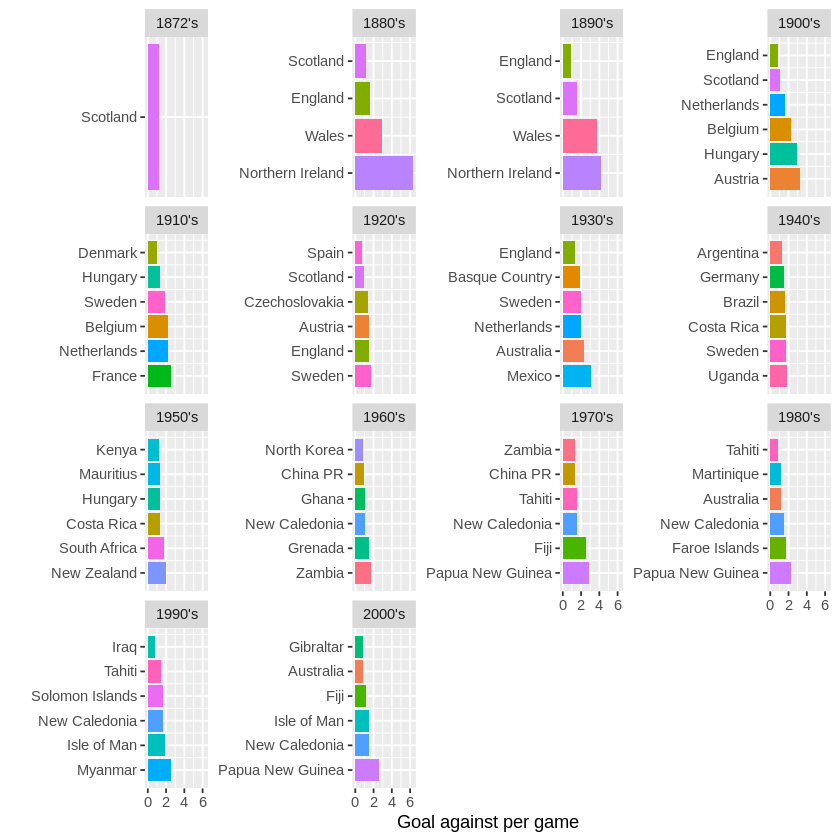

In [23]:
df_teams_goals_per_decade_top_ga <- df_teams_goals_per_decade %>%
    group_by(decade_year) %>%
    filter(total_games > 10) %>%
    top_n(n=6, wt=gf_per_game) %>%
    ungroup() %>%
    arrange(desc(decade_year), ga_per_game) %>%
    mutate(ord = rev(row_number())) 

ggplot(df_teams_goals_per_decade_top_ga, aes(x=ord, y=ga_per_game, fill=team)) + 
    geom_bar(stat="identity") +
    facet_wrap(~decade_year, scales="free_y") +
    coord_flip() +
    scale_x_continuous(labels=df_teams_goals_per_decade_top_ga$team, 
                     breaks=df_teams_goals_per_decade_top_ga$ord) +
labs(x="", y="Goal against per game") +
guides(fill=FALSE)

Are defense and attack correlated, i.e. are the top scorers also the best defense?
Below, we can see that the teams scoring very few goals per game are also more likely to have a poorer defense. However, pat a given limit around 1.5 goals for per game, the quality of the defense remains rather constant.
In general, teams above the line generally have a bad defense given their attack level and teams below the line have a better defense given their attack stats.

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
Warning message:
“The following aesthetics were dropped during statistical transformation: colour
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”


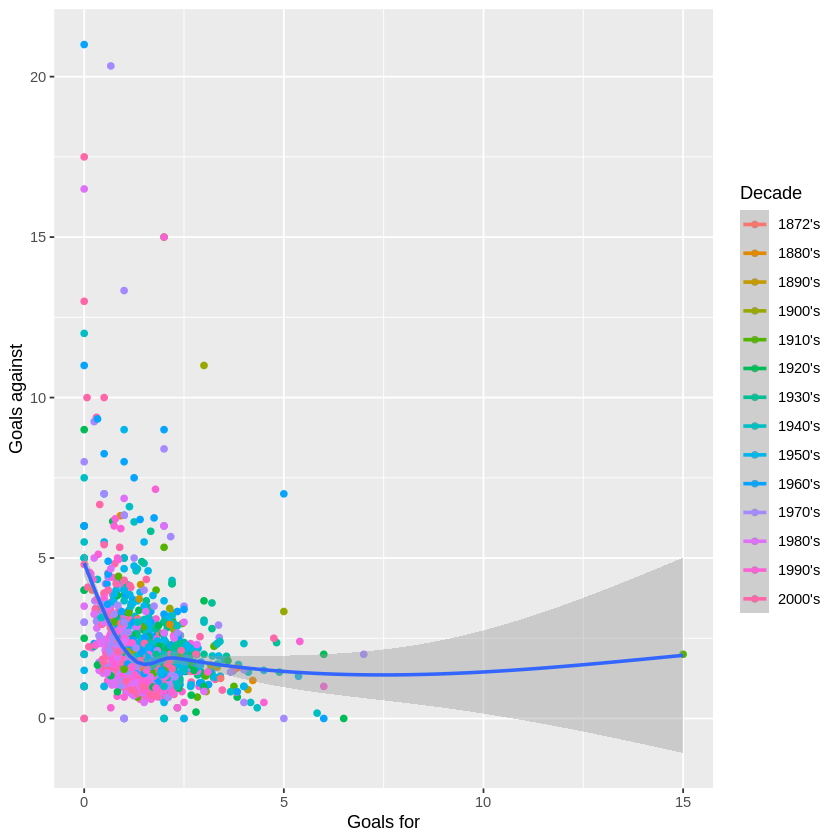

In [24]:
ggplot(df_teams_goals_per_decade, aes(x=gf_per_game, y=ga_per_game, colour=decade_year)) +
geom_point() +
geom_smooth(aes(group=1)) +
labs(x="Goals for", y="Goals against", colour="Decade")

`geom_smooth()` using formula = 'y ~ x'


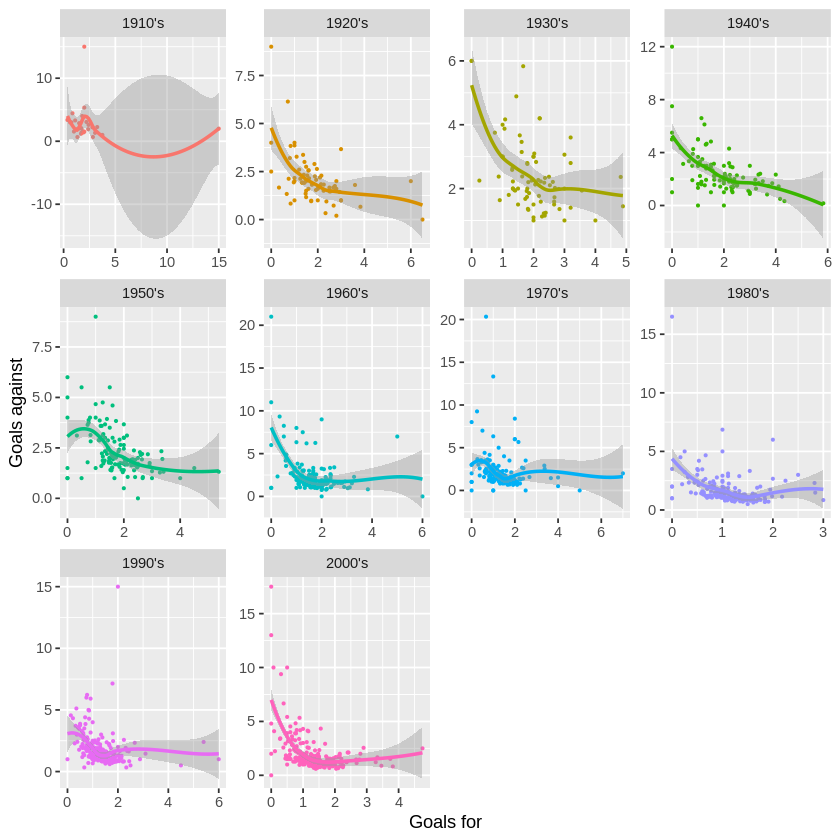

In [33]:
ggplot(df_teams_goals_per_decade %>% filter(min_year > 1900), aes(x=gf_per_game, y=ga_per_game, colour=decade_year)) +
geom_point(size=0.5) +
facet_wrap(~decade_year, scales="free") +
geom_smooth(aes(group=1), method="loess") +
labs(x="Goals for", y="Goals against") +
guides(colour=FALSE)


## Overall, which team has the best win ratio?

Now that we have looked at attack and defense, let's move to what finally matters the most: winning. It can be seen as fair to say that the most dominating team is the one that wins the highest number of games. Let's then compute the win ratio of all teams.

In [25]:
# Number of games per year per team

df_team_games_per_year <- all_teams %>%
    filter(year < 2018) %>%
    group_by(teams, year) %>%
    summarise(nb_games = length(year)) %>%
    mutate(year_date=as.Date(paste(year,"-01-01",sep="")))

# Number of victories per year
df_nb_victories <- df %>%
    mutate(year=as.numeric(year)) %>%
    select(year, winning_team) %>%
    filter(!is.na(winning_team)) %>%
    group_by(year, winning_team) %>%
    summarise(nb_victories = length(winning_team))

# Number of losses per year
df_nb_losses <- df %>%
    mutate(year=as.numeric(year)) %>%
    select(year, losing_team) %>%
    filter(!is.na(losing_team)) %>%
    group_by(year, losing_team) %>%
    summarise(nb_losses = length(losing_team))

# Putting all this together

df_teams_winrate <- df_team_games_per_year %>%
    left_join(df_nb_victories, by=c("year"="year", "teams"="winning_team")) %>%
    left_join(df_nb_losses, by=c("year", "teams"="losing_team")) %>%
    mutate(nb_victories = ifelse(is.na(nb_victories), 0, nb_victories)) %>%
    mutate(nb_losses = ifelse(is.na(nb_losses), 0, nb_losses)) %>%
    mutate(nb_ties = nb_games - (nb_victories + nb_losses))


`summarise()` has grouped output by 'teams'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


In [26]:
# Let's look overall

df_teams_winrate_overall <- df_teams_winrate %>%
    group_by(teams) %>%
    summarise(nb_games = sum(nb_games),
             nb_victories = sum(nb_victories),
             nb_losses = sum(nb_losses),
             nb_ties = sum(nb_ties)) %>%
    ungroup() %>%
    mutate(winrate = nb_victories / nb_games * 100,
          lossrate = nb_losses / nb_games * 100,
          tierate = nb_ties / nb_games * 100)



We will remove teams who played less than 100 games in total as they might have rather random win ratios (otherwise, the top 2 teams have a 100% win rate and... 1 game only).
This time, the top teams are not a surprise: Brazil, Germany and Spain. Some teams are more surprising such as New Caledonia. Together with Brazil, Argentina and Iran are the only non-European countries in this top 10. Czech Republic and Croatia also make it to this top 10.

In [27]:
df_teams_winrate_overall %>%
    filter(nb_games > 100) %>%
    arrange(desc(winrate)) %>%
    head(n=10)

teams,nb_games,nb_victories,nb_losses,nb_ties,winrate,lossrate,tierate
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Brazil,788,491,135,162,62.30964,17.13198,20.558376
Czech Republic,144,87,30,27,60.41667,20.83333,18.750000
Germany,755,430,168,157,56.95364,22.25166,20.794702
Tahiti,159,90,49,20,56.60377,30.81761,12.578616
England,840,469,167,204,55.83333,19.88095,24.285714
New Caledonia,156,85,58,13,54.48718,37.17949,8.333333
Italy,618,331,120,167,53.55987,19.41748,27.022654
Iran,305,163,67,75,53.44262,21.96721,24.590164
South Korea,659,351,135,173,53.26252,20.48558,26.251897


## Which are the best teams per decade

That's the question we all want to see answered! It came to no surprise that Brazil or Germany have the highest win ratios, but was it always the case? Which teams dominated the different eras of football.

In [28]:
df_teams_winrate_per_decade <- df_teams_winrate %>%
    mutate(decade = cut(year, seq(1870,2020, 10), dig.lab = 4, right=FALSE)) %>%
    group_by(teams, decade) %>%
    summarise(nb_games = sum(nb_games),
             nb_victories = sum(nb_victories),
             nb_losses = sum(nb_losses),
             nb_ties = sum(nb_ties),
             min_year = min(year)) %>%
    ungroup() %>%
    mutate(winrate = nb_victories / nb_games * 100,
          lossrate = nb_losses / nb_games * 100,
          tierate = nb_ties / nb_games * 100) 



`summarise()` has grouped output by 'teams'. You can override using the
`.groups` argument.


In [29]:
df_teams_winrate_per_decade_cleaned <- df_teams_winrate_per_decade %>%
    filter(nb_games > 10) %>% 
    group_by(decade) %>%
    mutate(min_year = min(min_year)) %>%
    top_n(n=6, wt=winrate) %>%
    ungroup() %>%
    arrange(desc(decade), desc(winrate)) %>%
    mutate(ord = rev(row_number())) 




Here are some interesting findings we can collect form the plot below:

* England used to be on the top teams. There were little competition at the time but there almost always in the top 6 teamsuntil the 1960's but were never back to this eleite club since then.
* Egypt or Iran are some made it twice to the top 6 since the 1970's.
* More or less expectedly, Argentina and Korea also are some of the teams regularly present in the top 5.
* Brazil has consistently been in the top 5 for the last 8 decades, that's the most striking performance and a strong indicator that they have been the most regular team in the (semi-) recent history of soccer. They occupied the top spot three decades in a row, from the 1970's to the 1990's.
* Germany can be considered as the second most regular team, making it 7 times in the top 5 in the last 9 decades. However, they never reached the first position.
* Spain's domination in the recent history of football is clearly visible here as they have occupied the top spot of this ranking during the last two decades (although the current one is yet to be finised).

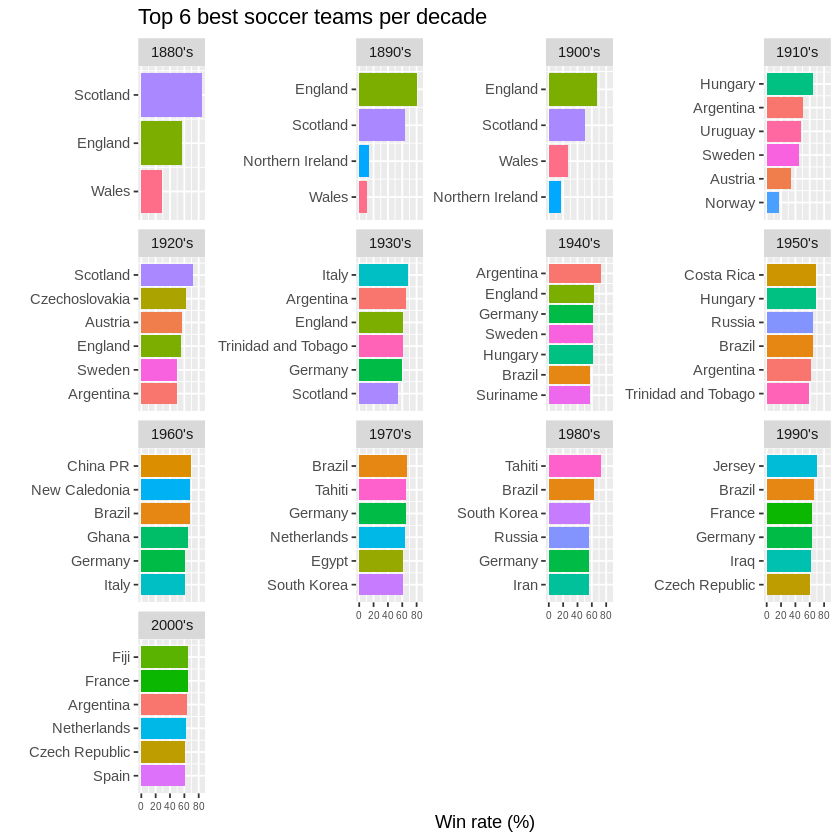

In [30]:
df_teams_winrate_per_decade_cleaned2 <- df_teams_winrate_per_decade %>%
    filter(nb_games > 25) %>% 
    group_by(decade) %>%
    mutate(min_year = min(min_year)) %>%
    top_n(n=6, wt=winrate) %>%
    ungroup() %>%
    arrange(desc(decade), desc(winrate)) %>%
    mutate(ord = rev(row_number())) %>%
    mutate(decade_year = paste(min_year, "'s", sep=""))




ggplot(df_teams_winrate_per_decade_cleaned2, aes(x=ord, y=winrate, fill=teams)) + 
    geom_bar(stat="identity") +
    facet_wrap(~decade_year, scales="free_y") +
    coord_flip() +
    scale_x_continuous(labels=df_teams_winrate_per_decade_cleaned2$teams, 
                     breaks=df_teams_winrate_per_decade_cleaned2$ord) +
labs(x="", y="Win rate (%)", title="Top 6 best soccer teams per decade") +
guides(fill=FALSE) + theme(axis.text.x=element_text(size=6))